In [12]:
import cv2
import matplotlib.pyplot as plt
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import easyocr
from PIL import Image, ImageEnhance
import numpy as np

In [252]:
def preprocess_image(image_path):   

    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Calculate the new dimensions
    new_height = int(height * 2)
    new_width = int(width * 2)

    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))


    pil_image = Image.fromarray(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    
    enhancer = ImageEnhance.Contrast(pil_image)
    contrast_img = enhancer.enhance(1.5)

    enhancer = ImageEnhance.Brightness(contrast_img)
    bright_img = enhancer.enhance(1.2)

    sharper = ImageEnhance.Sharpness(bright_img)
    sharper_img = sharper.enhance(2)

    enhanced_image = cv2.cvtColor(np.array(sharper_img), cv2.COLOR_RGB2BGR)
    
    gray = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    blurred = cv2.GaussianBlur(binary, (5, 5), 0)


    unsharp_mask = cv2.addWeighted(gray, 2, blurred, -1, 0)
    
    return unsharp_mask


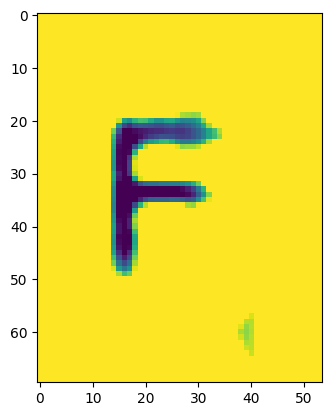

In [253]:

path = r'C:\Users\pc\Desktop\lp BigData\s6\cropped_3.jpg'

img = preprocess_image(path)
plt.imshow(img)

Using CPU. Note: This module is much faster with a GPU.


[[[[10, 16], [36, 16], [36, 50], [10, 50]], 'F']]


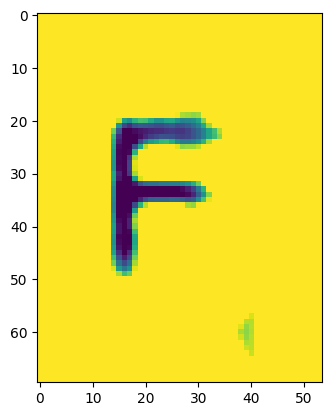

In [254]:

reader = easyocr.Reader(['fr'], gpu=False) 
res = reader.readtext(img, paragraph=True)

plt.imshow(img)
print(res)

In [255]:
import pytesseract

In [256]:

img = Image.open(path)
# img = preprocess_image(path)

text = pytesseract.image_to_string(img)
    
print(text)

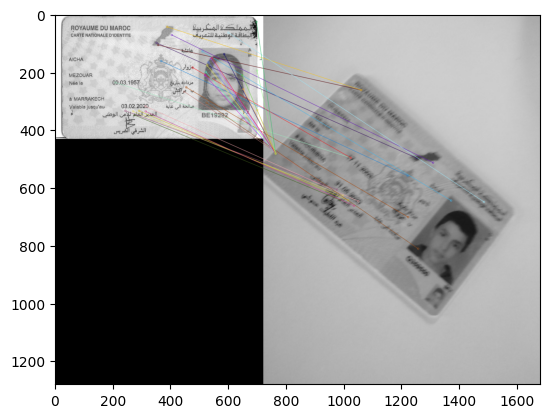

In [37]:
import cv2

# Load the images
image_original = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\moroccan_idCard_scanner\ids\old_card\id_1_3.jpg', cv2.IMREAD_GRAYSCALE)
image_rotated = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\test_crop\crop3.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints_original, descriptors_original = sift.detectAndCompute(image_original, None)
keypoints_rotated, descriptors_rotated = sift.detectAndCompute(image_rotated, None)

# Match descriptors using FLANN (Fast Library for Approximate Nearest Neighbors)
flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
matches = flann.knnMatch(descriptors_original, descriptors_rotated, k=2)

# Ratio test to find good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Draw matches
image_matches = cv2.drawMatches(image_original, keypoints_original, image_rotated, keypoints_rotated, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(image_matches)

# Display the matches
# cv2.imshow('Matches', image_matches)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [59]:
import cv2
import numpy as np

# Load reference card images
old_front = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\card_references\old_front.jpg', cv2.IMREAD_GRAYSCALE)
old_back = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\card_references\old_back.jpg', cv2.IMREAD_GRAYSCALE)
new_front = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\card_references\new_front.jpg', cv2.IMREAD_GRAYSCALE)
new_back = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\card_references\new_back.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

def extract_features(image):
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def match_features(descriptors1, descriptors2):
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    return len(good_matches)



def find_most_similar_card(input_card):
    scores = []
    keypoints_input, descriptors_input = extract_features(input_card)
    for ref_card in [old_front, old_back, new_front, new_back]:
        keypoints_ref, descriptors_ref = extract_features(ref_card)
        score = match_features(descriptors_input, descriptors_ref)
        scores.append(score)
    most_similar_card_type = np.argmax(scores) + 1  # Card types are numbered from 1 to 4
    return most_similar_card_type

# Example usage
input_card_image = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\test_crop\crop5.jpg', cv2.IMREAD_GRAYSCALE)
most_similar_card_type= find_most_similar_card(input_card_image)
print("Most similar card type:", most_similar_card_type)


Most similar card type: 1
